# Time Series Forecasting with Transformer and HF Trainer

Dataset: UCI Household Power Consumption (~2 million rows)
Model: Transformer-based Forecasting
Framework: Hugging Face Trainer API

In [1]:
!pip install -q transformers datasets torch accelerate pandas numpy matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments

In [3]:
# Download dataset
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!unzip -o household_power_consumption.zip

Archive:  household_power_consumption.zip
  inflating: household_power_consumption.txt  


In [4]:
# Load dataset
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    parse_dates={'dt': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values=['?'],
    low_memory=False
)

# Fill missing values
df['Global_active_power'] = df['Global_active_power'].fillna(method='ffill')
df = df.sort_values('dt').reset_index(drop=True)
df_hourly = df.set_index('dt').resample('H').mean().reset_index()
values = df_hourly['Global_active_power'].values.astype('float32')

print('Total rows:', len(values))
df_hourly.head()

/tmp/ipython-input-746783442.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/tmp/ipython-input-746783442.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/tmp/ipython-input-746783442.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(
/tmp/ipython-input-746783442.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Global_active_power'] = df['Global_active_power'].fillna(metho

Total rows: 34589


,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [5]:
# Sliding window dataset
WINDOW = 24  # 1 day
X, y = [], []
for i in range(len(values) - WINDOW):
    X.append(values[i:i+WINDOW])
    y.append(values[i+WINDOW])
X = np.array(X)
y = np.array(y)
print('Input shape:', X.shape, 'Labels shape:', y.shape)

Input shape: (34565, 24) Labels shape: (34565,)


In [6]:
# Train/test split
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
# PyTorch dataset
class TS_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return {'input_values': self.X[idx], 'labels': self.y[idx]}

train_ds = TS_Dataset(X_train, y_train)
test_ds = TS_Dataset(X_test, y_test)

In [8]:
# Transformer model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_len):
        super().__init__()
        self.embedding = nn.Linear(1, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=8)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.fc = nn.Linear(64, 1)

    def forward(self, input_values, labels=None):
        x = input_values.unsqueeze(-1)
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        out = self.fc(x[-1]).squeeze(-1)
        loss = None
        if labels is not None:
            loss = nn.MSELoss()(out, labels)
        return {'loss': loss, 'logits': out}

model = TimeSeriesTransformer(WINDOW)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [11]:
!pip install -U transformers


In [13]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=1e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    logging_steps=100,
    eval_steps=500,   # evaluate every 500 steps instead of using evaluation_strategy
    report_to='none'
)

def collate_fn(batch):
    input_values = torch.stack([item['input_values'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    return {'input_values': input_values, 'labels': labels}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn
)

In [14]:
# Train
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,0.457200
200,0.418000
300,0.413900
400,0.418400
500,0.402400
600,0.404200
700,0.404300
800,0.400400
900,0.410800
1000,0.415700


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1461, training_loss=0.40962341564473514, metrics={'train_runtime': 743.2184, 'train_samples_per_second': 125.567, 'train_steps_per_second': 1.966, 'total_flos': 0.0, 'train_loss': 0.40962341564473514, 'epoch': 3.0})

In [15]:
# Evaluate
metrics = trainer.evaluate()
print(metrics)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.26738712191581726, 'eval_runtime': 4.1724, 'eval_samples_per_second': 828.541, 'eval_steps_per_second': 13.182, 'epoch': 3.0}


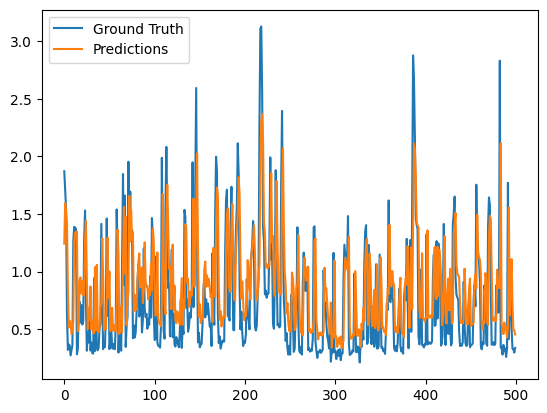

In [16]:
# Quick plot of predictions vs ground truth
preds = trainer.predict(test_ds).predictions
plt.plot(y_test[:500], label='Ground Truth')
plt.plot(preds[:500], label='Predictions')
plt.legend()
plt.show()

## Notes
- Dataset: Household Power Consumption (~2M rows)
- Transformer architecture captures long-range dependencies
- Sliding window: 24-hour lookback
- HF Trainer handles training and evaluation
- Ready for GitHub submission